In [1]:
from difflib import SequenceMatcher
import string
import numpy as np
import re

In [2]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/content/drive/MyDrive/kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c bengali-ged

In [ ]:
!unzip /content/bengali-ged.zip -d /content/

In [ ]:
import pandas as pd

In [13]:
df = pd.read_csv('/content/DataSetFold1_u.csv')

# types of error per token

 -- **extra space inclusion error** (Probably this can be handled by some rule based preprosessing, **not handled in this notebook**)

 -- **spanning error**, begin+end, easy to decode, replace $ at end or begin, sample 7632

 -- **one word error**, tricky with punctuation 7057, how to replace $$, place before punctuation, sample 8482

 -- **insertion error**, \\$\\$ with punctuation, replace \\$\\$, always at the end? sample 5202, 2, 

 -- **deletion error**, always at the end?, sample 5548

tags def

**one word error**, look at begin dollar or look for end dollar, decode method: replace with dollar (Note. if there is a punctuation at the end of the word, the last \\$ should be placed before the punctuation. **Not coded in this notebook.** Here dollar is placed in the start and end of a token)

**insertion error**, $$ with punctiation, decode method: replace dollar at the end

**deletion error**, $$ with empty, decode method: replace dollar at the end

**2 error**, not sure how to handle this, if found repalced with \\$token\\$\\$\\$

**1_5 error**, not sure how to handle this, if found repalced with token\\$\\$\\$

In [14]:
puncs = [item for item in string.punctuation if item!='$']+['।','"']

In [15]:
puncs

['!',
 '"',
 '#',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~',
 '।',
 '"']

In [ ]:
np.random.seed(42)
# encode
sentence_labels = []
label_broken = [] 
for ind in range(50):
    print('==============================================================')
    ind  = np.random.randint(0,len(df))
    print(ind)
    # ind = 9071
    source_sent = df.sentence[ind]
    target_sent = df['gt'][ind]
    print('sentence:', source_sent)
    print('gt:',target_sent)
    source_tokens = source_sent.split()
    target_tokens = target_sent.split()
    matcher = SequenceMatcher(None, source_tokens, target_tokens)
    diffs = list(matcher.get_opcodes())
    all_edits = []
#     print(source_tokens, target_tokens)
    labels_token = []
    for diff in diffs:
        tag, i1, i2, j1, j2 = diff
        print('----------------------------------------------------')
#         print(diff)
#         print(source_tokens[i1:i2], target_tokens[j1:j2], tag)
        if tag != 'equal':
            for s_t, t_t in zip(source_tokens[i1:i2], target_tokens[j1:j2]):
                label = None
                dollars = re.findall('[$]', t_t)
                # label begin/end error
                if len(dollars)==1:
                    #remove punc before searching
                    t_t_no_punc = ''.join([s for s in t_t if s not in puncs])

                    if t_t_no_punc[0] == '$':
                        label = 'begin_err'
                    if t_t_no_punc[-1] == '$':
                        label = 'end_err'
                    
                # label one word error/insertion/deletion
                if len(dollars) == 2:
    #                 span = re.search('(\$.?\$)+',t_t).span()
                    span = re.search('\$.*?\$',t_t).span()
                    _string = t_t[span[0]:span[1]].replace('$','')
    #                 print(string)
                    if len(_string)==0:
                        label = 'del_err'
                    else:
                        if np.all([s in puncs for s in _string]):
                            label = 'punc_insert_err'
                        else:
                            label = 'one_word_err'
                # multiple error
                if len(dollars) == 4:
                    label = '2_err'
                if len(dollars) == 3:
                    label = '1-5_err'
                print(t_t, label)
                labels_token.append(label)
                if label in ['2_err', '1-5_err', None]:
                    print('label',label, t_t, ind)  
                
        else:
            for s_t, t_t in zip(source_tokens[i1:i2], target_tokens[j1:j2]):
                label = '0'
                print(t_t, label)
                labels_token.append(label)
    if len(source_tokens) != len(labels_token):
        label_broken.append(True)
    else:
        label_broken.append(False)
    sentence_labels.append(labels_token)



7270
sentence: বর্তমানে আইন কমিশন একজন চেয়ারম্যান ও দুজন সদস্য সমন্বয়ে গঠিত।
gt: বর্তমানে আইন কমিশন একজন চেয়ারম্যান ও দুজন সদস্য সমন্বয়ে গঠিত।
----------------------------------------------------
বর্তমানে 0
আইন 0
কমিশন 0
একজন 0
চেয়ারম্যান 0
ও 0
দুজন 0
সদস্য 0
সমন্বয়ে 0
গঠিত। 0
860
sentence: হিতোশি সাকামোতো এই সংস্করণের অডিওর জন্য দায়ী ছিলেন।
gt: হিতোশি সাকামোতো$$ এই সংস্করণের অডিওর জন্য দায়ী ছিলেন।
----------------------------------------------------
হিতোশি 0
----------------------------------------------------
সাকামোতো$$ del_err
----------------------------------------------------
এই 0
সংস্করণের 0
অডিওর 0
জন্য 0
দায়ী 0
ছিলেন। 0
5390
sentence: ঘুম থেকে আমাদের ওঠানো হতো।
gt: ঘুম থেকে আমাদের ওঠানো হতো।
----------------------------------------------------
ঘুম 0
থেকে 0
আমাদের 0
ওঠানো 0
হতো। 0
5191
sentence: নিজেকে একজন সাধারণ মানুষ ভেবে সবার সঙ্গে মিশে একসঙ্গে কাজ করতেন।
gt: নিজেকে একজন সাধারণ মানুষ ভেবে সবার সঙ্গে মিশে একসঙ্গে কাজ করতেন।
------------------------------------------

In [ ]:
import Levenshtein

In [ ]:
Levenshtein.distance('qweert','232qwer')

5

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
# np.random.seed(42)
# encode
sentence_labels = []
label_broken = [] 
for ind in range(len(df)):
#     print('==============================================================')
#     ind  = np.random.randint(0,len(df))
#     print(ind)
    # ind = 9071
    source_sent = df.sentence[ind]
    target_sent = df['gt'][ind]
#     print('sentence', source_sent)
#     print('gt',target_sent)
    source_tokens = source_sent.split()
    target_tokens = target_sent.split()
    matcher = SequenceMatcher(None, source_tokens, target_tokens)
    diffs = list(matcher.get_opcodes())
    all_edits = []
#     print(source_tokens, target_tokens)
    labels_token = []
    for diff in diffs:
        tag, i1, i2, j1, j2 = diff
#         print('----------------------------------------------------')
#         print(diff)
#         print(source_tokens[i1:i2], target_tokens[j1:j2], tag)
        if tag != 'equal':
            for s_t, t_t in zip(source_tokens[i1:i2], target_tokens[j1:j2]):
                label = None
                dollars = re.findall('[$]', t_t)
                # label begin/end error
                if len(dollars)==1:
                    #remove punc before searching
                    t_t_no_punc = ''.join([s for s in t_t if s not in puncs])

                    if t_t_no_punc[0] == '$':
                        label = 'begin_err'
                    if t_t_no_punc[-1] == '$':
                        label = 'end_err'
                    
                # label one word error/insertion/deletion
                if len(dollars) == 2:
    #                 span = re.search('(\$.?\$)+',t_t).span()
                    span = re.search('\$.*?\$',t_t).span()
                    _string = t_t[span[0]:span[1]].replace('$','')
    #                 print(string)
                    if len(_string)==0:
                        label = 'del_err'
                    else:
                        if np.all([s in puncs for s in _string]):
                            label = 'punc_insert_err'
                        else:
                            label = 'one_word_err'
                # multiple error
                if len(dollars) == 4:
                    label = '2_err'
#                 print(t_t, label)
                if len(dollars) == 3:
                    label = '1-5_err'
#                 print(t_t, label)
                labels_token.append(label)
                if label in [None]:
                    print('label',label, t_t, ind)  
                

        else:
            for s_t, t_t in zip(source_tokens[i1:i2], target_tokens[j1:j2]):
                label = '0'
#                 print(t_t, label)
                labels_token.append(label)
    if len(source_tokens) != len(labels_token):
        label_broken.append(True)
    else:
        label_broken.append(False)
    sentence_labels.append(labels_token)



label None $হইছে$$,$$আরো$ 96
label None সবজি$,$হালুয়া$,$ডাল$,$দই 1146
label None থাইল্যান্ড$,$মালয়েশিয়া$,$চায়না$,$কোরিয়া$,$জাপান 1641
label None শয়তান$,$ইবলিশ$,$নরপিশাচ$,$শুয়ার$,$কুত্তা$,$অমানুষ$ 1956
label None জনাব$_$ইসমাইল$_$চৌধুরী$_$সম্রাট 3601
label None কোন$াে 4282
label None বিরোধী$আন্দোলন 4980
label None $করেনা$$,$$অনেক 4987
label None টা$দেখবা 5888
label None তে$তার 7563
label None কোন$টা 7848
label None কোন$টা 7848
label None কোন$মতেই 8306


In [ ]:
df['sentence'][8306], df['gt'][8306]

('মতামতের জন্য কবি কোনমতেই দায়ী নয় এবং সেক্ষেত্রে মহামান্য এডমিনের সিদ্ধান্ত চুড়ান্ত বলে বিবেচিত হবে।',
 'মতামতের জন্য কবি$ কোন$মতেই দায়ী নয় এবং সেক্ষেত্রে মহামান্য এডমিনের সিদ্ধান্ত চুড়ান্ত বলে বিবেচিত হবে।')

In [ ]:
sum(label_broken), len(label_broken)

(1, 9380)

In [ ]:
df['sentence_labels'] = sentence_labels
df['source_tokens'] = df.sentence.apply(lambda x: x.split())

# df_filtered =df[]
df_filtered = df[np.logical_and(
    [None  not in sl for sl  in sentence_labels],
    np.logical_not(label_broken)
)]

In [ ]:
flat_list = [item for sublist in df_filtered.sentence_labels for item in sublist]


In [ ]:
import matplotlib.pyplot as plt

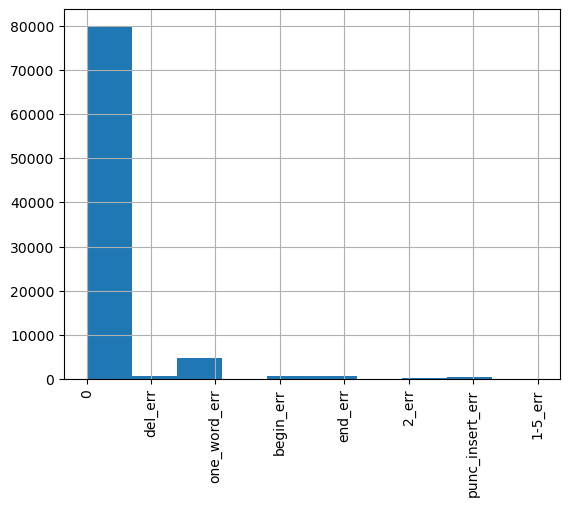

In [ ]:
pd.Series(flat_list).hist()
_=plt.xticks(rotation = 90)

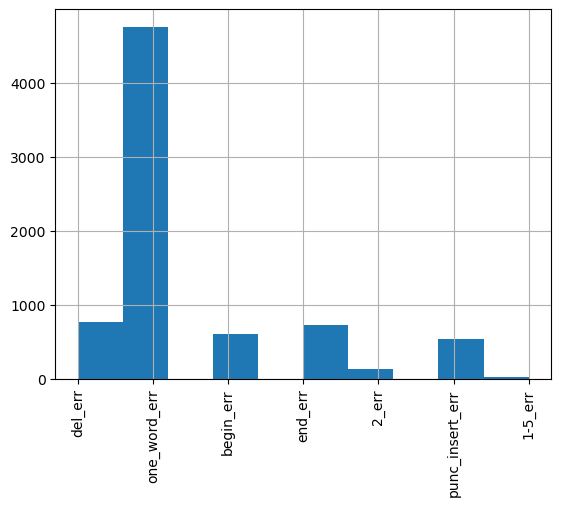

In [ ]:
pd.Series([l for l in flat_list if l!='0']).hist()
_=plt.xticks(rotation = 90)

In [ ]:
# #decode
# # np.random.seed(42)
# # encode
# distance = 0
# df_filter = df[np.logical_not(label_broken)]
# for ind in df_filter.index:
# #     print('==============================================================')
# #     ind  = np.random.randint(0,len(df))
# #     print(ind)
#     # ind = 9071
#     source_sent = df_filter.sentence[ind]
#     target_sent = df_filter['gt'][ind]
#     source_tokens = source_sent.split()
#     labels_token = df_filter['sentence_labels'][ind]
#     pred_tokens = []
#     for s_t, lbl in zip(source_tokens, labels_token):
#         prd = None
#         if lbl == 'begin_err':
#             prd = '$'+s_t
#         if lbl == 'end_err':
#             prd = s_t+'$'
#         if lbl == 'del_err':
#             prd = s_t+'$$'
#         if lbl == 'punc_insert_err':
#             prd = s_t+'$$'
#         if lbl == '2_err':
#             prd = '$'+s_t+'$$$'
#         if lbl == '1-5_err':
#             prd = s_t+'$$$'
#         if lbl == 'one_word_err':
#             prd = '$'+s_t+'$'
#         if lbl== 0:
#             prd = s_t
#         if lbl is None:
#             prd = s_t
#         if prd is None:
#             print(lbl)
#         pred_tokens.append(prd)
#     pred_sent = ' '.join(pred_tokens)
#     distance+=Levenshtein.distance(pred_sent, target_sent)
# #     print('sentence', source_sent)
# #     print('gt',target_sent)
    
# #     target_tokens = target_sent.split()
# print(distance/len(df_filter))

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df_train, df_test = train_test_split(df_filtered, test_size = 0.05, random_state=42)

In [ ]:
train_list = [{'tokens': x, 'tags': y} for x,y in zip(df_train.source_tokens,df_train.sentence_labels)]
test_list = [{'tokens': x, 'tags': y} for x,y in zip(df_train.source_tokens,df_train.sentence_labels)]

In [ ]:
# !rm -r banglabert/

In [ ]:
# !rm -r outputs/

In [ ]:
!git clone https://github.com/Reasat/banglabert.git

Cloning into 'banglabert'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 158 (delta 82), reused 71 (delta 23), pack-reused 0
Receiving objects: 100% (158/158), 1.11 MiB | 3.91 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [ ]:
!pip install seqeval==1.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 510.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16179 sha256=1dc2e7e30c6d865eac8f26903a4aea4db6c2d54705a4a3dc758bd48cfe068170
  Stored in directory: /root/.cache/pip/wheels/b2/a1/b7/0d3b008d0c77cd57332d724b92cf7650b4185b493dc785f00a
Successfully built seqeval


In [ ]:
!pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-89bdx9pv
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-89bdx9pv
  Resolved https://github.com/csebuetnlp/normalizer to commit d80c3c484e1b80268f2b2dfaf7557fe65e34f321
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6883 sha256=ff27d9fb82a384331fa2123b98dbbab0fc4a577cbb3cf6d377717020dd637034
  Stored in directory: /tmp/pip-ephem-wheel-cache-gzf_p7so/wheels/af/b1/ee/b9e2a2f2dd861976a357b6a6fa105aeedf2254016676f6cf8f
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186469 sha256=cc659982afb358bf1257677d8102

In [ ]:
'O' == '0'

False

In [ ]:
import json
with open("banglabert/token_classification/sample_inputs/train.jsonl", 'w') as f:
    for item in train_list:
        f.write(json.dumps(item) + "\n")

with open("banglabert/token_classification/sample_inputs/validation.jsonl", 'w') as f:
    for item in test_list:
        f.write(json.dumps(item) + "\n")

with open("banglabert/token_classification/sample_inputs/test.jsonl", 'w') as f:
    for item in test_list:
        f.write(json.dumps(item) + "\n")

In [ ]:
!python banglabert/token_classification/token_classification.py \
    --model_name_or_path "csebuetnlp/banglabert" \
    --dataset_dir "banglabert/token_classification/sample_inputs/" \
    --output_dir "outputs/" \
    --learning_rate=2e-5 \
    --warmup_ratio 0.1 \
    --gradient_accumulation_steps 2 \
    --weight_decay 0.1 \
    --lr_scheduler_type "linear"  \
    --per_device_train_batch_size=16 \
    --per_device_eval_batch_size=16 \
    --max_seq_length 512 \
    --logging_strategy "epoch" \
    --save_strategy "epoch" \
    --save_total_limit 1 \
    --evaluation_strategy "epoch" \
    --num_train_epochs=30 --do_train --do_eval

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Extracting data files: 100%|████████████████████| 3/3 [00:00<00:00, 1394.23it/s]
Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-9574438aecea9a21/0.0.0. Subsequent calls will reuse this data.
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 580.66it/s]
[INFO|configuration_utils.py:660] 2023-02-28 17:57:18,162 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--csebuetnlp--banglabert/snapshots/9ce791f330578f50da6bc52b54205166fb5d1c8c/config.json
[INFO|configuration_utils.py:712] 2023-02-28 17:57:18,169 >> Model config ElectraConfig {
  "_name_or_path": "csebuetnlp/banglabert",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": n

In [ ]:
abul = pd.read_csv('/kaggle/input/bengali-ged/SampleSubmission.csv')

In [ ]:
test_list_kaggle = [{'tokens': item.split(), 'tags': ['0']*len(item.split())} for item in abul.Expected]
with open("banglabert/token_classification/sample_inputs/test.jsonl", 'w') as f:
    for item in test_list_kaggle:
        f.write(json.dumps(item) + "\n")

In [ ]:
!python banglabert/token_classification/token_classification.py \
    --model_name_or_path outputs/\
    --dataset_dir "banglabert/token_classification/sample_inputs/" \
    --output_dir "banglabert/token_classification/outputs_eval/" \
    --per_device_eval_batch_size=16 \
    --overwrite_output_dir \
    --do_predict

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Extracting data files: 100%|█████████████████████| 3/3 [00:00<00:00, 585.99it/s]
Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-406a9cd30d259d65/0.0.0. Subsequent calls will reuse this data.
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 733.31it/s]
[INFO|configuration_utils.py:658] 2023-02-28 18:25:59,893 >> loading configuration file outputs/config.json
[INFO|configuration_utils.py:712] 2023-02-28 18:25:59,900 >> Model config ElectraConfig {
  "_name_or_path": "outputs/",
  "architectures": [
    "ElectraForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "0"

In [ ]:
with open("banglabert/token_classification/outputs_eval/predictions.txt",'r') as f:
    preds = f.readlines()
#     preds =  for l in preds

In [ ]:
# for x,y in zip(abul.Expected,preds):
#     source_tokens = x.split()
#     labels = y.split()
#     print('============================================================================')
#     for a,b in zip(source_tokens, labels):
#         print(a,b)

In [ ]:
#decode
# np.random.seed(42)
# encode
preds_all = []
for x,y in zip(abul.Expected,preds):
#     print('==============================================================')
#     ind  = np.random.randint(0,len(df))
#     print(ind)
    # ind = 9071
    source_sent = x
    source_tokens = source_sent.split()
    labels = y.split()
    pred_tokens = []
    for s_t, lbl in zip(source_tokens, labels):
        prd = None
        if lbl == 'begin_err':
            prd = '$'+s_t
        if lbl == 'end_err':
            prd = s_t+'$'
        if lbl == 'del_err':
            prd = s_t+'$$'
        if lbl == 'punc_insert_err':
            prd = s_t+'$$'
        if lbl == '2_err':
            prd = '$'+s_t+'$$$'
        if lbl == '1-5_err':
            prd = s_t+'$$$'
        if lbl == 'one_word_err':
            prd = '$'+s_t+'$'
        if lbl== '0':
            prd = s_t
        if lbl is None:
            prd = s_t
        if prd is None:
            print(lbl)
        pred_tokens.append(prd)
#         print(pred_tokens)
    pred_sent = ' '.join(pred_tokens)
    print('sentence', source_sent)
    print('pred',pred_sent)
    preds_all.append(pred_sent)
#     target_tokens = target_sent.split()
# print(distance/len(df_filter))

sentence ব্যক্তি থেকেই শুরু যার সমাপ্তি হবে বিশ্বে মুসলিমদের মহত্ত্বের চর্চায় যেমনটি আগে ছিল রাসূলের আদর্শে আছে।
pred ব্যক্তি থেকেই শুরু যার সমাপ্তি হবে বিশ্বে মুসলিমদের মহত্ত্বের চর্চায় যেমনটি আগে ছিল রাসূলের আদর্শে আছে।
sentence ইউনিটগণ, পিছিয়ে যান।
pred ইউনিটগণ, পিছিয়ে যান।
sentence ভিক্টোরিয়ার ক্লেটন ক্যাম্পাসে ছয়টি আবাসিক হল রয়েছে।
pred ভিক্টোরিয়ার ক্লেটন ক্যাম্পাসে ছয়টি আবাসিক হল রয়েছে।
sentence তেমনি আবির একটা বইপোঁকা সেটা বললে ভুল হবেনা।
pred তেমনি আবির একটা বইপোঁকা সেটা বললে ভুল $হবেনা।$
sentence আমরা চাই গরিব চাচা যেন তারনেয্য টাকা পিরে পায় এবং সারা বাংলাদেসে যমুনা টিবির সুনাম বয়ে জায়
pred আমরা চাই গরিব চাচা যেন $তারনেয্য$ টাকা $পিরে$ পায় এবং সারা $বাংলাদেসে$ যমুনা টিবির সুনাম বয়ে $জায়$$$
sentence আমি একজন আদনান ভাইকে খুজছি ।
pred আমি একজন আদনান ভাইকে $খুজছি$ ।$$
sentence এই দুটি শহর শত শত কিলোমিটারের ব্যবধানে অবস্থিত।
pred এই দুটি শহর শত শত কিলোমিটারের ব্যবধানে অবস্থিত।
sentence খেলার সময় ক্রোবারকে পিছনে রাখা হলেও ছোট ডেফনিকে প্রাধান্য দেন।
pred খেলার সময় ক্রোবারকে প

In [ ]:
df_pred = abul.copy()
df_pred.Expected = preds_all
df_pred.to_csv('submission.csv', index = False)